In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

In [3]:
Stromal_markers = {
    'Endothelial' : ['VWF', 'CDH5', 'ACE', 'PECAM1'], # SELP = CD62P
    'Fibroblast' : ['COL1A2', 'COL3A1', 'VIM', 'ADAMDEC1', 'DCN', 'SLIT2', 'CXCL12', 'F3', 'SOX6', 'PDGFRA' ],
    # 'CAF' : ['ACTA2', 'PDGFRB', 'NECTIN2', ],
    # 'apCAF' : ['HLA-DRA', 'CD74'],
    # 'myoCAF' : ['MUSTN1', 'ACTA2'],
    # 'iCAF' : ['IL6'],
    'Pericyte' : ['CSPG4', 'RGS5', 'COL1A1', 'PDGFRB', 'ACTA2', 'DES'], # CSPG4 = NG2
}

## Load data

In [3]:
adata_joanito_TME = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/TME_annot_temp_files/Joanito.preprocessed.NanoMnT.nonTumor.preAnnot.h5ad')

In [4]:
dict_BiopsySite_to_BiopsySite2 = {
    'Adjacent normal tissue' : 'Normal',
    'Normal' : 'Normal',
    'Core' : 'Tumor',
    'Tumor' : 'Tumor',
    'Invasive' : 'Tumor',
    'LymphNode' : 'LymphNode',
}

In [5]:
dict_Identifier_to_lvl_1_CellType = dict()
dict_Identifier_to_lvl_2_CellType = dict()

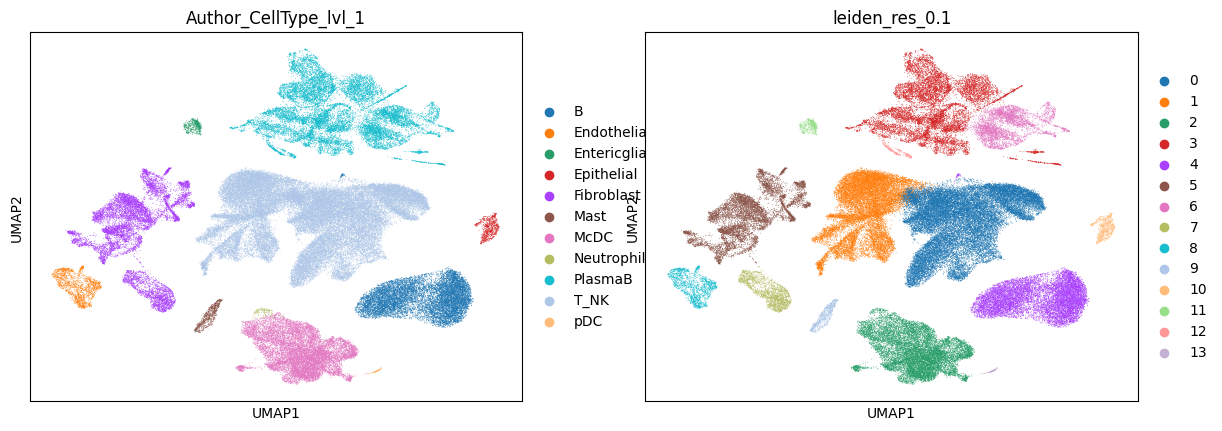

In [6]:
sc.pl.umap(adata_joanito_TME, color=['Author_CellType_lvl_1', 'leiden_res_0.1'])

## Stromal cells - leiden_res_0.1: 5, 7, 8, 11

In [11]:
adata_joanito_sml = adata_joanito_TME[adata_joanito_TME.obs['leiden_res_0.1'].isin(['5', '7', '8', '11'])].copy()
adata_joanito_sml = adata_joanito_sml.raw.to_adata()

In [12]:
sc.pp.normalize_total(adata_joanito_sml)
sc.pp.log1p(adata_joanito_sml)
sc.pp.highly_variable_genes(adata_joanito_sml, n_top_genes=2000, batch_key="SampleID")

adata_joanito_sml.raw = adata_joanito_sml.copy()
adata_joanito_sml = adata_joanito_sml[:, adata_joanito_sml.var.highly_variable]

sc.pp.scale(adata_joanito_sml, max_value=10)
sc.tl.pca(adata_joanito_sml, svd_solver="arpack")

sc.pp.neighbors(adata_joanito_sml, n_neighbors=20, n_pcs=40)
sc.tl.umap(adata_joanito_sml, random_state=42)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.tl.leiden(adata_joanito_sml, resolution=0.2, key_added='sub1_leiden')

/tmp/ipykernel_228213/1885849424.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_joanito_sml, resolution=0.2, key_added='sub1_leiden')


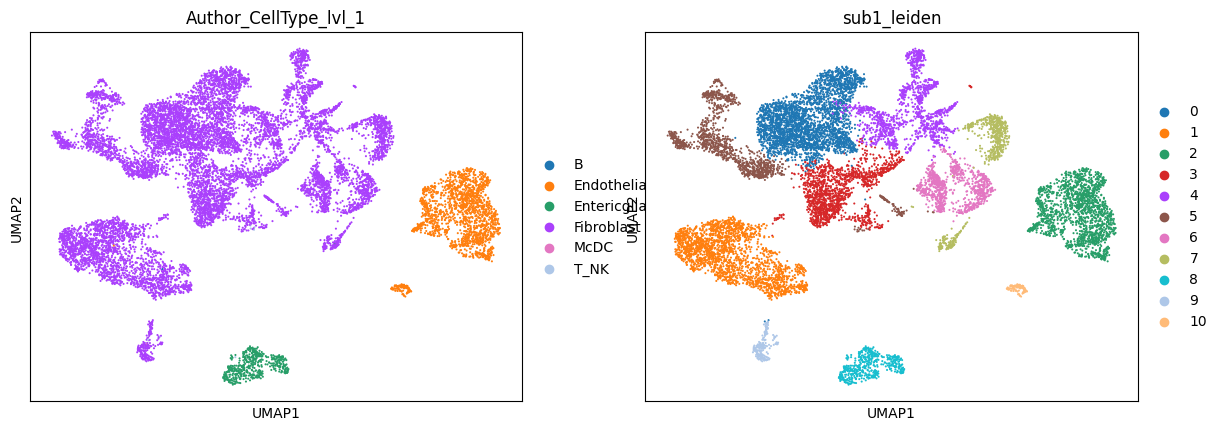

In [22]:
sc.pl.umap(adata_joanito_sml, color=['Author_CellType_lvl_1', 'sub1_leiden',], ncols=2)

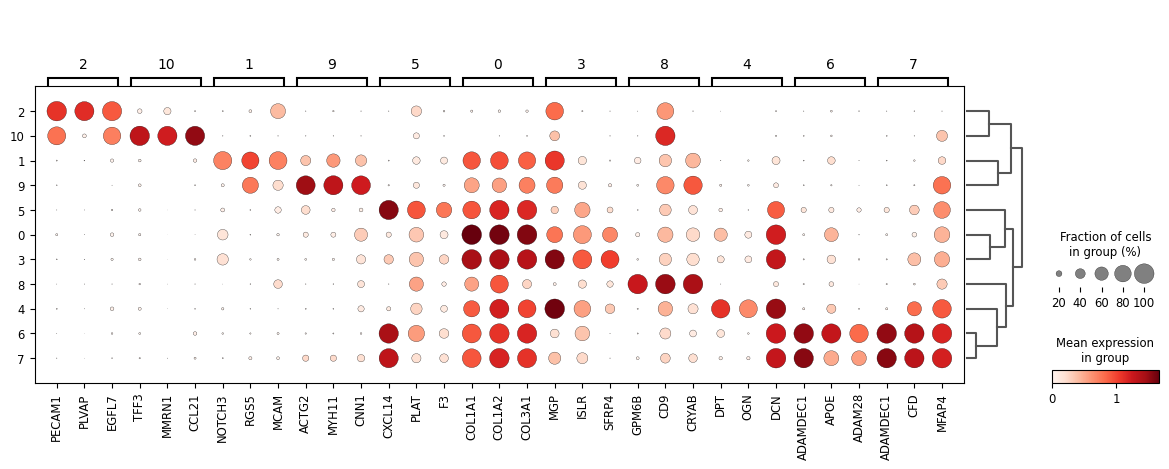

In [16]:
sc.tl.rank_genes_groups(adata_joanito_sml, groupby='sub1_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_joanito_sml, n_genes=3, groupby='sub1_leiden')

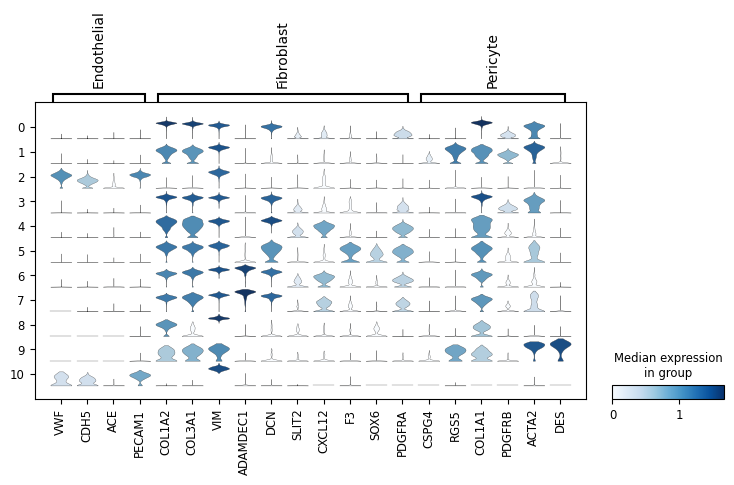

In [19]:
# Confirming endothelial identity when compared to other clusters
sc.pl.stacked_violin(adata_joanito_sml, var_names=Stromal_markers, groupby='sub1_leiden')

In [27]:
pd.DataFrame(adata_joanito_sml.uns['rank_genes_groups']['names']).T

,0,1,2,3,4,5,6,7,8,9,...,29501,29502,29503,29504,29505,29506,29507,29508,29509,29510
0,COL1A1,COL1A2,COL3A1,CTHRC1,COL11A1,COL5A2,MFAP2,THBS2,POSTN,AEBP1,...,PCBP2,SPTBN1,STOM,ZFP36,IL6ST,NFIA,RBMS3,ITM2B,SPARCL1,A2M
1,NOTCH3,RGS5,MCAM,NDUFA4L2,EPS8,COL18A1,DBNDD2,GJA4,ADIRF,CRIP1,...,RARRES2,CTSK,S100A13,PDGFRA,VCAN,S100A10,DCN,LUM,PLXDC2,MMP2
2,PECAM1,PLVAP,EGFL7,VWF,RAMP2,RNASE1,ADGRL4,ECSCR,CD93,FKBP1A,...,COL6A2,LGALS3BP,CALD1,FTH1,TPM2,C1S,COL1A1,RARRES2,COL3A1,COL1A2
3,MGP,ISLR,SFRP4,TIMP1,PRELP,OLFML2B,BGN,VCAN,COL10A1,SFRP2,...,PDE4D,RPS26,MT-CO2,S100A4,EPAS1,MT-CO1,S100A6,MT-CYB,MT-ATP8,MT-CO3
4,DPT,OGN,DCN,MGP,CCDC80,SRPX,HSPB6,CXCL12,C7,MGST1,...,FLNA,ID3,TPM1,PDLIM3,B2M,PDLIM1,MYLK,HLA-B,IGFBP7,MYH9
5,CXCL14,PLAT,F3,NSG1,SOX6,TMEM176B,PDGFRA,FENDRR,MCTP2,AGT,...,MARCKS,COL15A1,IGFBP4,NRP1,UBE2E2,COL18A1,MGP,PRSS23,SPARCL1,FN1
6,ADAMDEC1,APOE,ADAM28,CFD,TCF21,SCARA5,CTSC,TMEM176B,TMEM176A,MFAP4,...,THBS2,TSHZ2,SPARC,CAVIN1,TAGLN,CAV1,MYL12A,CLIC4,MGP,BGN
7,ADAMDEC1,CFD,MFAP4,PDK4,ADH1B,ZBTB16,SELENOP,TMEM176B,FHL1,LTBP4,...,TIMP1,TSHZ2,ARPC2,IL32,IGFBP4,ARPC1B,GAPDH,BGN,S100A11,IGFBP7
8,GPM6B,CD9,CRYAB,FXYD1,CLU,CDH19,NRXN1,S100B,PLP1,PMP22,...,PRKG1,BGN,MGP,MYH9,TAGLN,SERPINF1,TPM2,CALD1,PPIC,IFITM1
9,ACTG2,MYH11,CNN1,RAMP1,MYLK,DES,TPM2,TAGLN,MYL9,KCNMB1,...,VCAN,TFPI,TAGLN2,IFITM1,DCN,PCOLCE,EMP1,VIM,SERPINF1,SPARC


### leiden 2, 10 → Endothelial

In [20]:
for tup in adata_joanito_sml[(adata_joanito_sml.obs['sub1_leiden'].isin(['2', '10']))].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Stromal'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Endothelial'

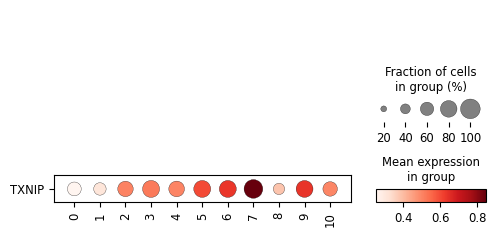

In [50]:
sc.pl.dotplot(adata_joanito_sml, var_names=['TXNIP'], groupby='sub1_leiden', swap_axes=True,)

### leiden 8 → Entericglial cells

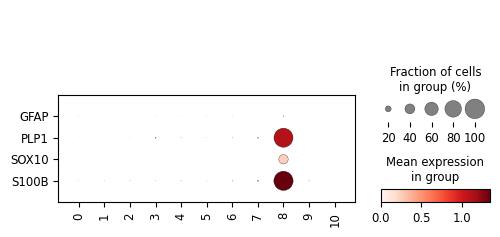

In [30]:
sc.pl.dotplot(adata_joanito_sml, var_names=['GFAP', 'PLP1', 'SOX10', 'S100B'], groupby='sub1_leiden', swap_axes=True,)

In [46]:
for tup in adata_joanito_sml[(adata_joanito_sml.obs['sub1_leiden'].isin(['8']))].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Glial' #! Not really stromal
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Glial'

### Other leidens → Mixture of various fibroblast/SMC/pericytes?

In [32]:
adata_joanito_sml_subset = adata_joanito_sml[~(adata_joanito_sml.obs['sub1_leiden'].isin(['2', '8', '10']))].copy()
adata_joanito_sml_subset = adata_joanito_sml_subset.raw.to_adata()

temp = list()
for SampleID, edf in adata_joanito_sml_subset.obs.groupby('SampleID'):
    if len(edf) <= 1:
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Stromal'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_joanito_sml_subset = adata_joanito_sml_subset[~(adata_joanito_sml_subset.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_joanito_sml_subset)
sc.pp.log1p(adata_joanito_sml_subset)
sc.pp.highly_variable_genes(adata_joanito_sml_subset, n_top_genes=2000, batch_key='SampleID')

adata_joanito_sml_subset.raw = adata_joanito_sml_subset.copy()
adata_joanito_sml_subset = adata_joanito_sml_subset[:, adata_joanito_sml_subset.var.highly_variable]

sc.pp.scale(adata_joanito_sml_subset, max_value=10)
sc.tl.pca(adata_joanito_sml_subset, svd_solver="arpack")

sc.tl.leiden(adata_joanito_sml_subset, resolution=0.2, key_added='sub2_leiden')

/tmp/ipykernel_228213/3795963716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_joanito_sml_subset.obs.groupby('SampleID'):


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [42]:
adata_joanito_sml_subset.obs['BiopsySite2'] = [ dict_BiopsySite_to_BiopsySite2[BS] for BS in adata_joanito_sml_subset.obs['BiopsySite'] ]

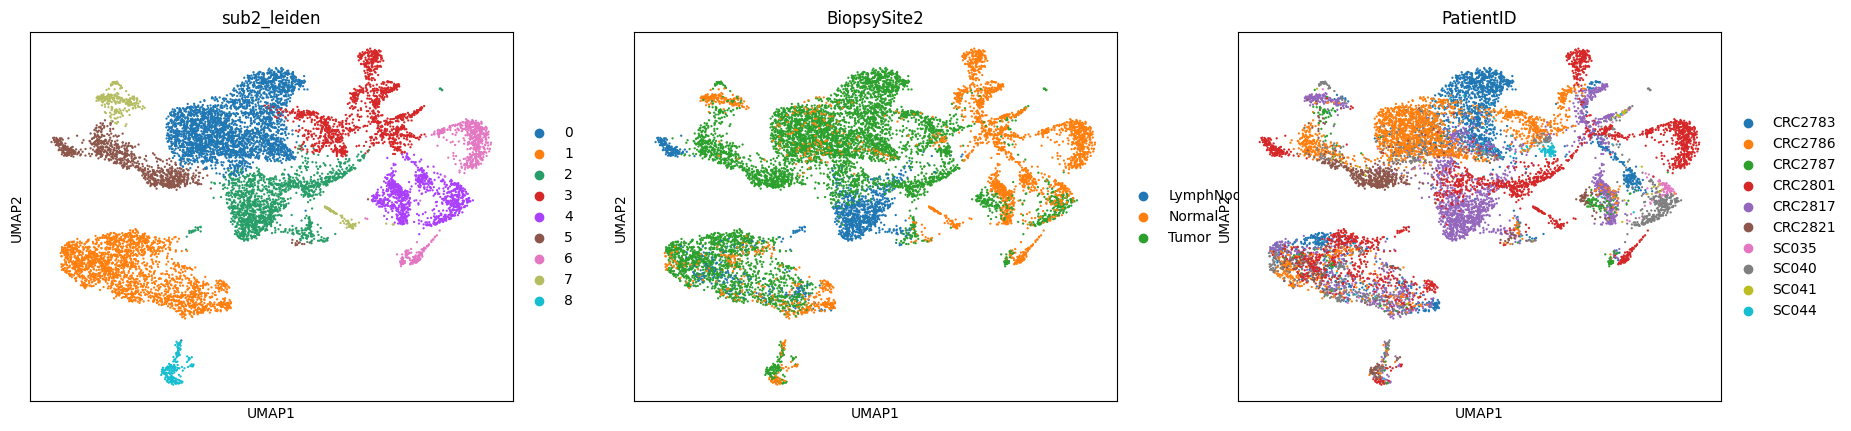

In [57]:
sc.pl.umap(adata_joanito_sml_subset, color=['sub2_leiden', 'BiopsySite2', 'PatientID'])

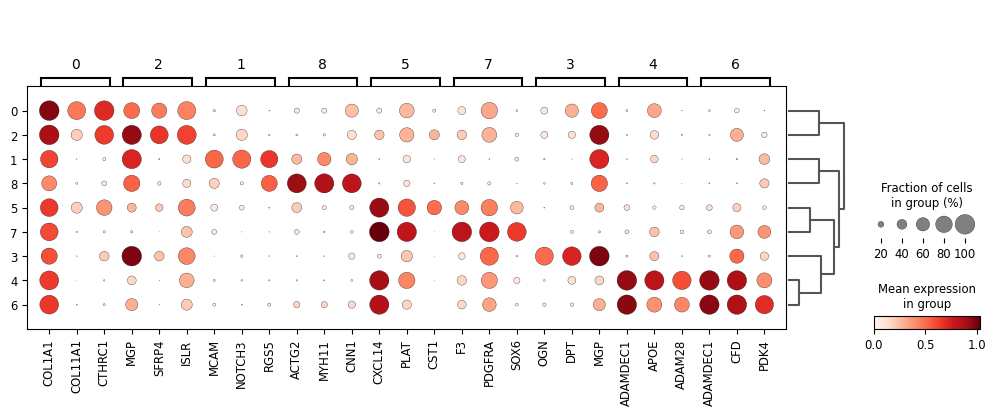

In [45]:
sc.tl.rank_genes_groups(adata_joanito_sml_subset, groupby='sub2_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_joanito_sml_subset, n_genes=3, groupby='sub2_leiden')

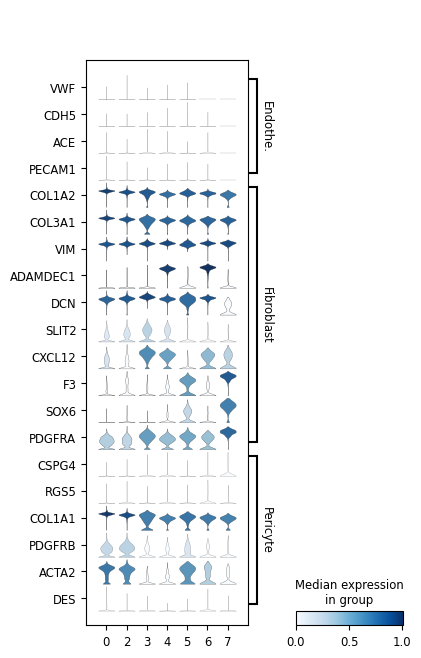

In [87]:
sc.pl.stacked_violin(adata_joanito_sml_subset[~(adata_joanito_sml_subset.obs['sub2_leiden'].isin(['1', '8']))], 
                     var_names=Stromal_markers, 
                     groupby='sub2_leiden', swap_axes=True,)

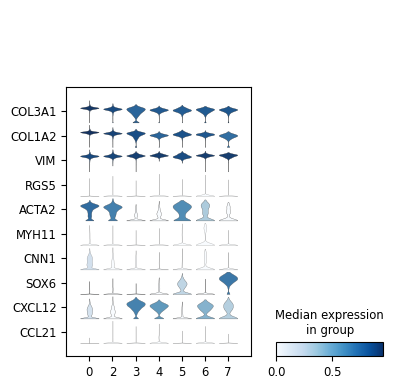

In [88]:
sc.pl.stacked_violin(adata_joanito_sml_subset[~(adata_joanito_sml_subset.obs['sub2_leiden'].isin(['1', '8']))], 
                     var_names=['COL3A1', 'COL1A2', 'VIM', # Fibroblast (broad) 
                                'RGS5', 'ACTA2',  # Pericyte 
                                'MYH11', 'CNN1',  # SMC
                                'SOX6', 'CXCL12', 'CCL21', # Fibroblast subtype
                                                          ], 
                     groupby='sub2_leiden', swap_axes=True,)

#### sub2_leiden 1 → Pericyte

In [111]:
# Strong RGS5 and other pericyte enriched gene expression
for tup in adata_joanito_sml_subset[adata_joanito_sml_subset.obs['sub2_leiden'].isin(['1'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Pericyte'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Pericyte'

#### sub2_leiden 8 → SMC

In [112]:
# Strong MYH11 and CNN1 expression
for tup in adata_joanito_sml_subset[adata_joanito_sml_subset.obs['sub2_leiden'].isin(['8'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'SMC'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'SMC'

#### sub2_leiden 0, 2 → ACTA2+ Fibroblast

In [117]:
for tup in adata_joanito_sml_subset[adata_joanito_sml_subset.obs['sub2_leiden'].isin(['0', '2'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Fibroblast'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'ACTA2+ Fibroblast'

#### sub2_leiden 3, 4, 6 → Fibroblast

In [107]:
for tup in adata_joanito_sml_subset[adata_joanito_sml_subset.obs['sub2_leiden'].isin(['3', '4', '6'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Fibroblast'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Fibroblast'

#### sub2_leiden 5, 7 → SOX6+ Fibroblast

In [118]:
for tup in adata_joanito_sml_subset[adata_joanito_sml_subset.obs['sub2_leiden'].isin(['5', '7'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Fibroblast'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'SOX6+ Fibroblast'

In [113]:
len(adata_joanito_sml), len(dict_Identifier_to_lvl_1_CellType)

(13403, 13403)

In [119]:
adata_joanito_sml.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType[Identifier] for Identifier in adata_joanito_sml.obs['Identifier'] ]
adata_joanito_sml.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType[Identifier] for Identifier in adata_joanito_sml.obs['Identifier'] ]


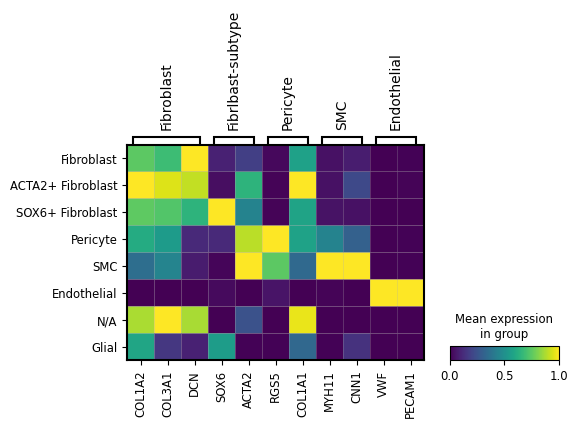

In [129]:
sc.pl.matrixplot(adata_joanito_sml, 
                 var_names={
                            'Fibroblast' : ['COL1A2', 'COL3A1', 'DCN'], 
                             'Fibrlbast-subtype' : ['SOX6', 'ACTA2'],
                            'Pericyte' : ['RGS5', 'COL1A1'], 
                            'SMC' : ['MYH11', 'CNN1'], 
                            'Endothelial' : ['VWF', 'PECAM1'],}, 
                 groupby='Manual_CellType_lvl_2',
                 standard_scale='var', 
                 categories_order=['Fibroblast', 'ACTA2+ Fibroblast', 'SOX6+ Fibroblast', 'Pericyte', 'SMC', 'Endothelial', 'N/A', 'Glial'],
                 )

In [131]:
saveWithPickle(dict_Identifier_to_lvl_1_CellType, '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType', 'Stromal.lvl1')
saveWithPickle(dict_Identifier_to_lvl_2_CellType, '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType', 'Stromal.lvl2')

## Label all TME cell types

In [5]:
dict_Identifier_to_lvl_1_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')

dict_Identifier_to_lvl_2_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')

dict_Identifier_to_lvl_1_CellType_Total,  dict_Identifier_to_lvl_2_CellType_Total = dict(), dict()

for k,v in dict_Identifier_to_lvl_1_CellType_1.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_2.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_3.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v

for k,v in dict_Identifier_to_lvl_2_CellType_1.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_2.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_3.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v

adata_joanito_TME.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType_Total[Identifier] for Identifier in adata_joanito_TME.obs['Identifier'] ]
adata_joanito_TME.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType_Total[Identifier] for Identifier in adata_joanito_TME.obs['Identifier'] ]

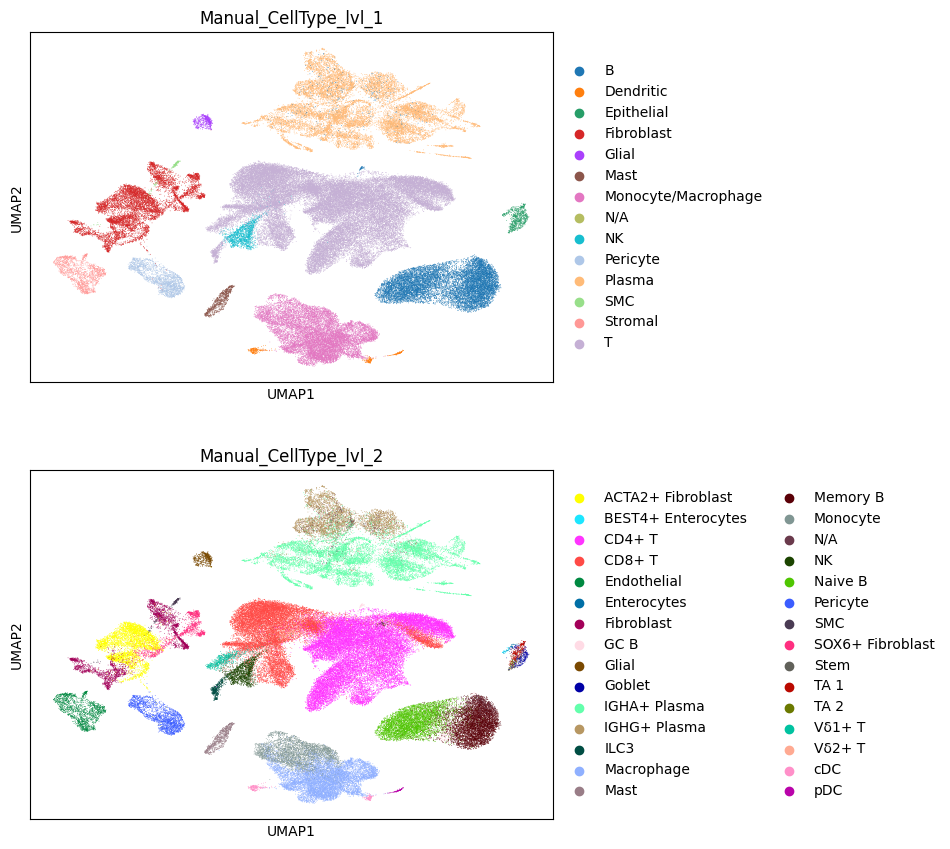

In [6]:
sc.pl.umap(adata_joanito_TME, color=['Manual_CellType_lvl_1', 'Manual_CellType_lvl_2'], ncols=1)

In [7]:
B_markers = { 'B' : ['MS4A1', 'CD79A', 'CD19'], 
            'Naive' : ["IGHD", 'IGHM', ],
            'Memory B' : ['CD27', 'CD24'], 
            'GC' : ['MEF2B', 'MCM3', ], 
}

Plasma_markers = {
    'Plasma' : ['SDC1', 'MZB1', 'DERL3'],
}

B_markers_total = dict()
for k,v in B_markers.items(): B_markers_total[k] = v
for k,v in Plasma_markers.items(): B_markers_total[k] = v
B_markers_total['IgG+'] = [ 'IGHG1', ]
B_markers_total['IgA+'] = [ 'IGHA1', ]

T_markers = {
    'T' : ['CD3D', 'CD3E', ],
    'Naive T' : ['PTPRC', 'IL7R', 'CCR7', 'FOXP1', 'SELL',],
    'CD4+ T' : ['CD4', 'FOXP3'], 
    'CD8+ T' : ['CD8A','GZMK'],
    'NK' : ['NCAM1', 'KLRD1', 'NKG7'],
    'Vδ1+ T' : ['TRDV1',],
    'Vδ2+ T' : ['TRDV2',],
    'Vδ3+ T' : ['TRDV3',],
    'ILC3' : ['RORC', 'IL7R', 'CCR6', 'KIT',],
}

Myeloid_markers = { 
                   'Mast' :         ['MS4A2', 'TPSAB1', 'TPSB2', 'CPA3' ], 
                   'Monocytes' :    ['CD14', ],
                   'Neutrophils' :  [ 'FCGR3A'], 
                   'pDC' :          ["GZMB", "IL3RA", 'CLEC4C',],
                   'cDC' :          ['ITGAX', 'ID2', 'IRF4', 'LAMP3', 'ZBTB46'],
                   }

Epithelial_markers = { 
                         'Intestinal stem' : ['LGR5', 'ASCL2',], 
                         'Goblet' : ['MUC2', 'FCGBP', 'CLCA1', 'ZG16', ], 
                         'Enterocytes' : ['SLC26A3', 'CLCA4', 'BEST4', ], 
                         'Enterocyte progenitors' : ['CA2', 'SELENBP1'], 
                         'Enteroendocrine' : ['PCSK1N', ], 
                         'Tuft' : ['POU2F3',],}

Stromal_markers = {
    'Endothelial' : ['VWF', 'CDH5', 'PECAM1'], # SELP = CD62P
    'Fibroblast' : ['COL1A2', 'COL3A1', 'ADAMDEC1', 'DCN', ],
    'Pericyte' : ['CSPG4', 'RGS5', ], # CSPG4 = NG2
    'SMC' : ['MYH11', 'CNN1'],
}

In [8]:
dict_marker_genes = dict()
for k,v in B_markers_total.items(): dict_marker_genes[k]=v
for k,v in T_markers.items(): dict_marker_genes[k]=v
for k,v in Myeloid_markers.items(): dict_marker_genes[k]=v
for k,v in Epithelial_markers.items(): dict_marker_genes[k]=v
for k,v in Stromal_markers.items(): dict_marker_genes[k]=v
len(dict_marker_genes)

31

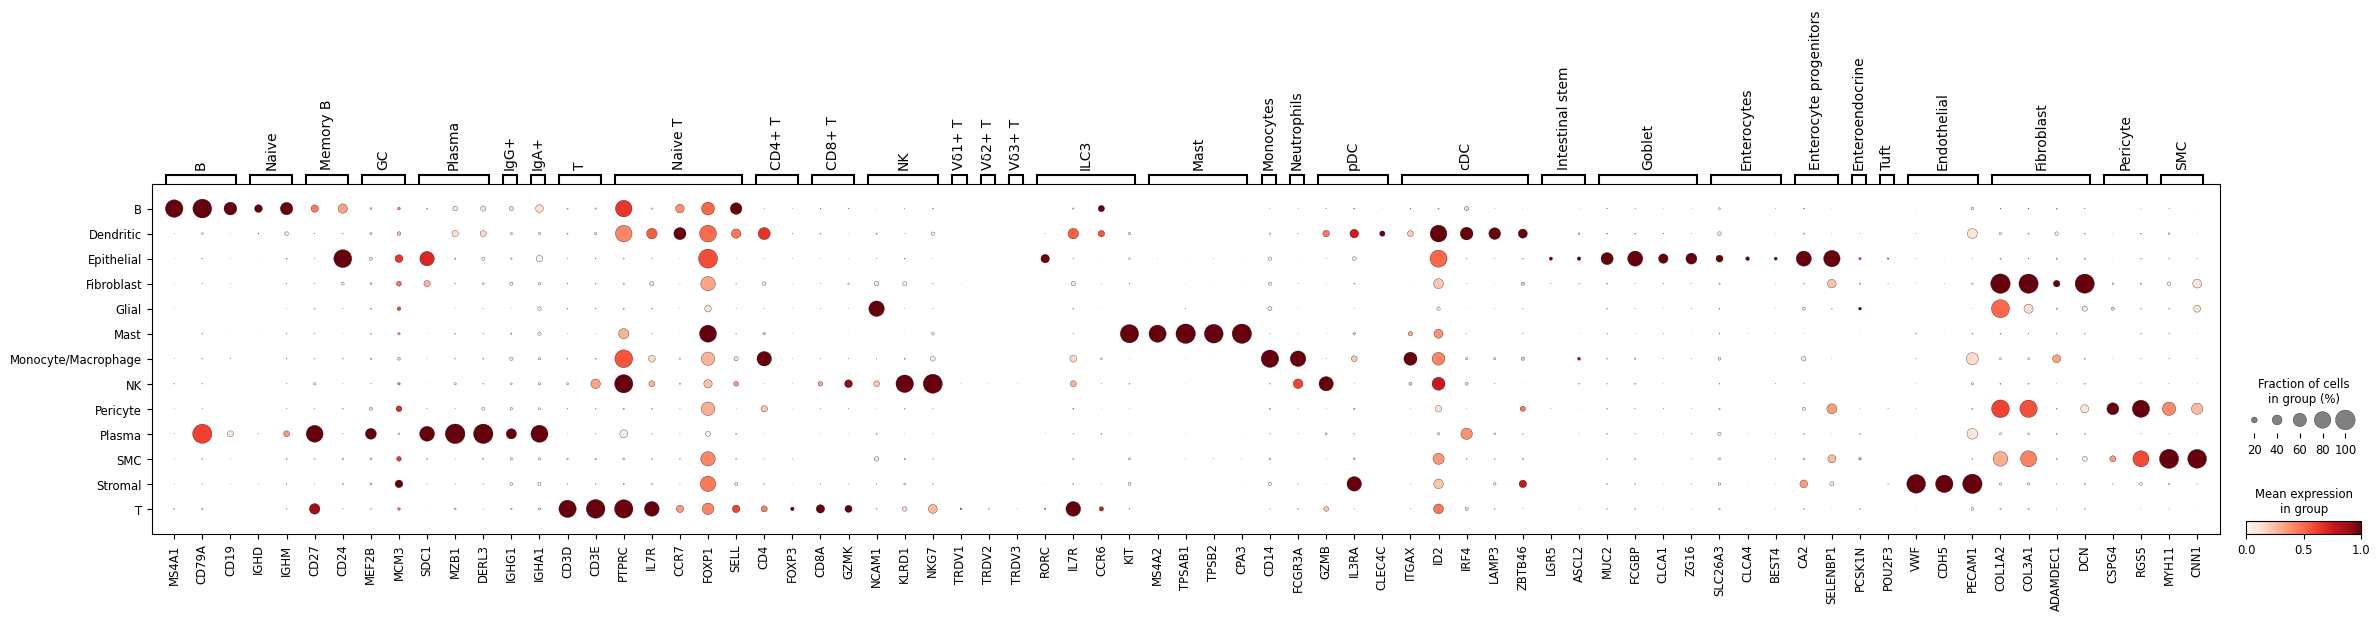

In [10]:
sc.pl.dotplot(adata_joanito_TME[adata_joanito_TME.obs['Manual_CellType_lvl_2']!='N/A'], var_names=dict_marker_genes, groupby='Manual_CellType_lvl_1', swap_axes=False, standard_scale='var', 
                #  categories_order=['B', 'Plasma', 'T', 'NK', 'Mast', 'Monocyte/Macrophage', 'Dendritic', 'Epithelial', 'Endothelial', 'Fibroblast', 'Pericyte',  'SMC', 'Glial']
                 )

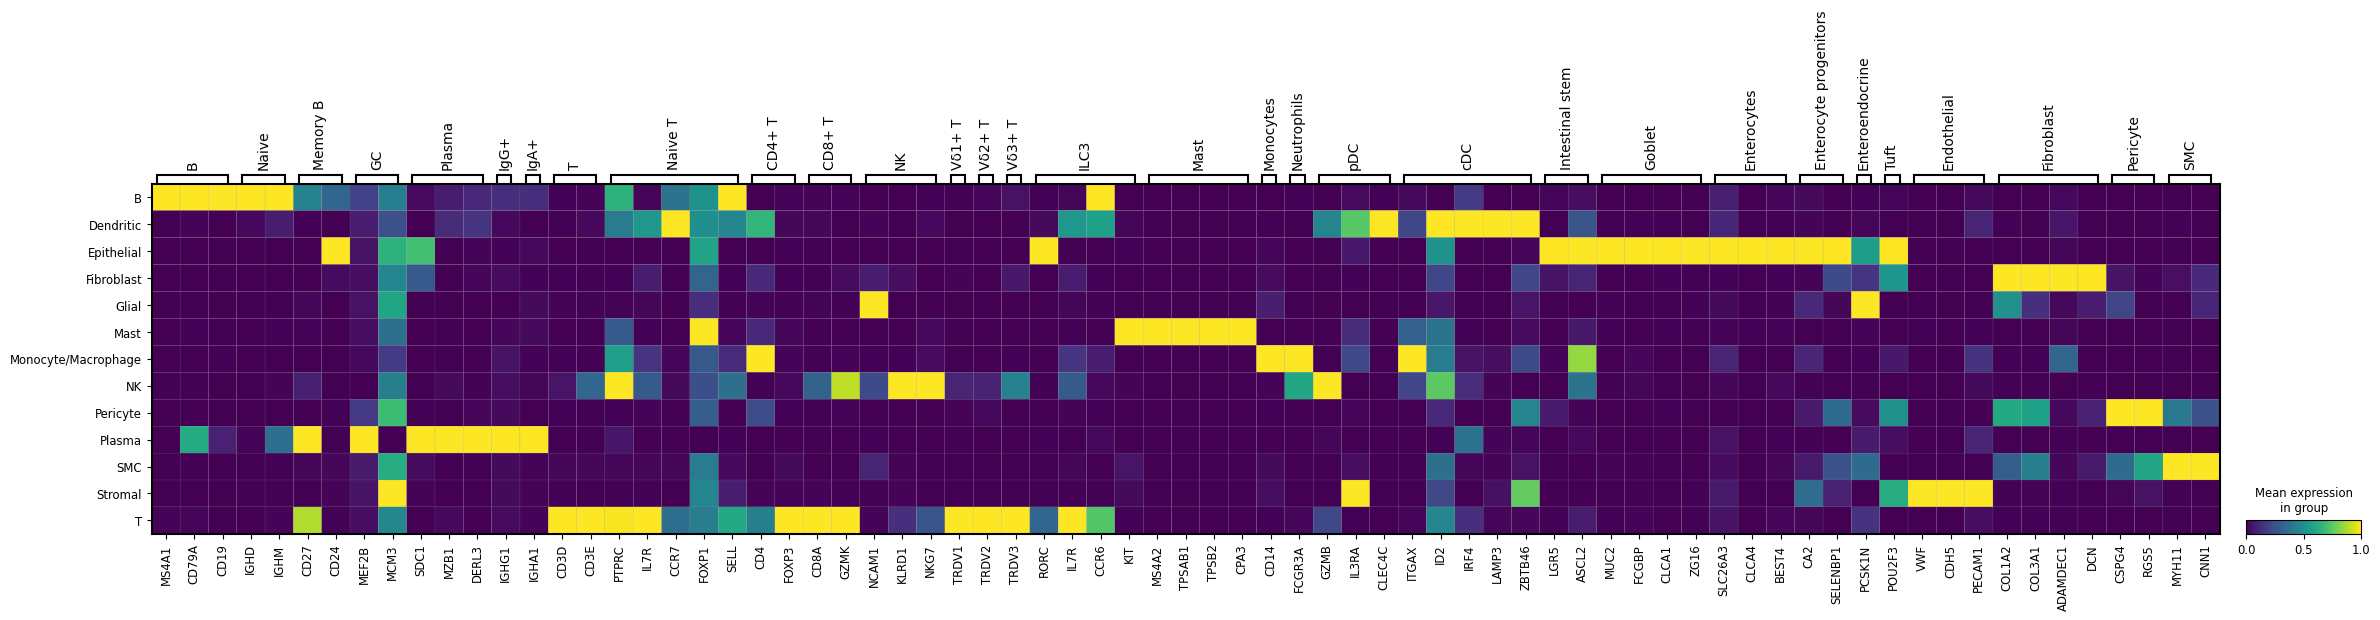

In [9]:
sc.pl.matrixplot(adata_joanito_TME[adata_joanito_TME.obs['Manual_CellType_lvl_2']!='N/A'], var_names=dict_marker_genes, groupby='Manual_CellType_lvl_1', swap_axes=False, standard_scale='var', 
                #  categories_order=['B', 'Plasma', 'T', 'NK', 'Mast', 'Monocyte/Macrophage', 'Dendritic', 'Epithelial', 'Endothelial', 'Fibroblast', 'Pericyte',  'SMC', 'Glial']
                 )

In [11]:
adata_joanito_TME.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.TME.h5ad')